<a href="https://colab.research.google.com/github/RobotKitchen/AppleCounting/blob/main/Approach1_RedChannelSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Approach 1: RGB-based Segmentation

Segmentation tool for the apples in the [MinneApple dataset](https://conservancy.umn.edu/handle/11299/206575) 



Import libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from scipy import ndimage # multidimensional image processing
from skimage.color import rgb2hsv # image processing algorithms

Segmentation based on RGB channels

Text(0.5, 1.0, 'Blue channel')

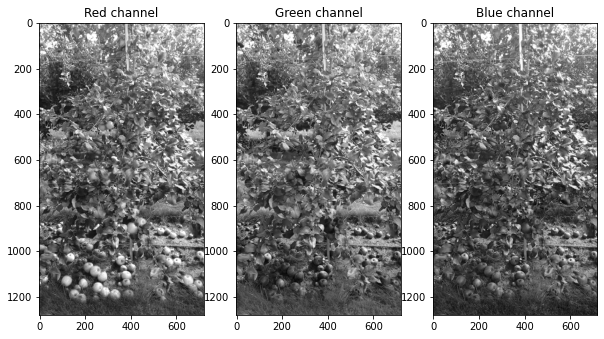

In [ ]:
# In the sample images the brightness is too uniform. 
img = cv2.imread('/content/apple.png')
hsv_img = rgb2hsv(img)
b,g,r = cv2.split(img)

plt.figure(figsize=(10, 10))
plt.title("Channel comparison")
plt.subplot(1,3,1)
r_plot = plt.imshow(r,cmap="gray")
plt.gca().set_title('Red channel')
plt.subplot(1,3,2)
g_plot = plt.imshow(g,cmap="gray")
plt.gca().set_title('Green channel')
plt.subplot(1,3,3)
b_plot = plt.imshow(b,cmap="gray")
plt.gca().set_title('Blue channel')

# Apples seem brighter in red! Using red channel

Equalize red channel for maximum contrast


Text(0.5, 1.0, 'hist equalised')

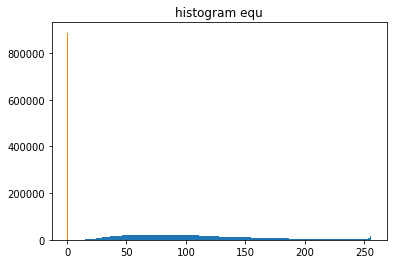

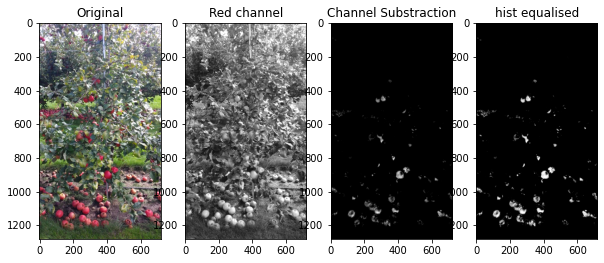

In [ ]:
# Just a little experiment, exclude all non-red info
img = cv2.imread('/content/apple.png')
b,g,r = cv2.split(img)

test = cv2.subtract(r,g)
test = cv2.subtract(test,b)

equ_test = cv2.equalizeHist(test)  # histogram equalisation

#hsv_img = rgb2hsv(img)

plt.figure()
plt.hist(img.ravel(),256,[0,256]);  # show histogram. numpy.ravel() - flatten an image, i.e. 2D->1D
plt.hist(equ_test.ravel(),256,[0,256]);
plt.title("histogram equ")

plt.figure(figsize=(10, 10))
plt.subplot(1,4,1)
plt.imshow(img[:,:,::-1])
plt.title("Original")
plt.subplot(1,4,2)
r_plot = plt.imshow(r,cmap="gray")
plt.gca().set_title('Red channel')
plt.subplot(1,4,3)
plt.imshow(test,cmap="gray")
plt.title("Channel Substraction")
plt.subplot(1,4,4)
plt.imshow(equ_test,cmap="gray")

plt.title("hist equalised")

Comparing different thresholding methods

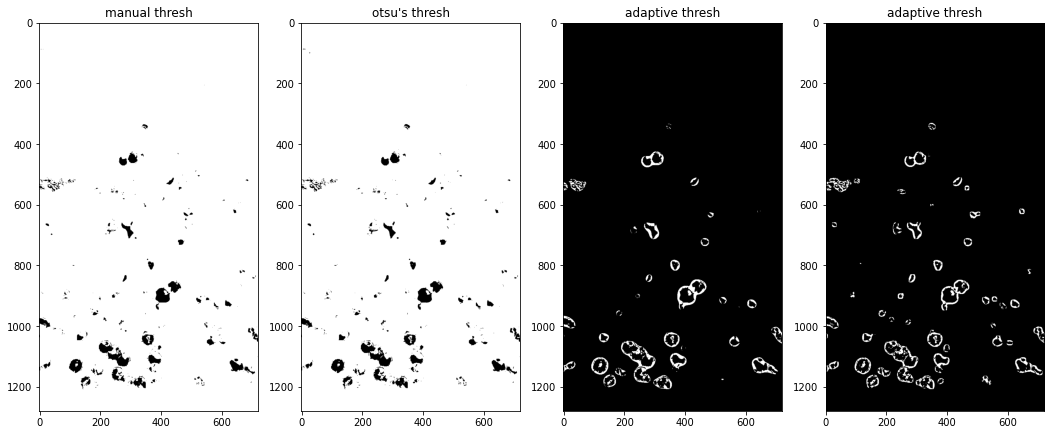

In [ ]:
thresh1, bw1 = cv2.threshold(equ_test, thresh=90, maxval=255, type=cv2.THRESH_BINARY_INV) # manually selected threshold, low values to 255
thresh2, bw2 = cv2.threshold(equ_test, thresh=100, maxval=255, type=cv2.THRESH_OTSU)      # otsu's method
bw3 = cv2.adaptiveThreshold(equ_test,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,51,30) # adaptive thresholding.
bw4 = cv2.adaptiveThreshold(equ_test,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,17,25) # adaptive thresholding.

# 301 is block size, 3 is sigma (standard deviation)

bw2 = np.invert(bw2) # invert image, i.e. swap black and whhite
bw3 = np.invert(bw3)
bw4 = np.invert(bw4)


plt.figure(figsize=(18, 8))
plt.subplot(1,4,1)
plt.imshow(bw1,cmap="gray")
plt.title("manual thresh")
plt.subplot(1,4,2)
plt.imshow(bw2,cmap="gray")
plt.title("otsu's thresh")
plt.subplot(1,4,3)
plt.imshow(bw3,cmap="gray")
plt.title("adaptive thresh")
plt.subplot(1,4,4)
plt.imshow(bw4,cmap="gray")
plt.title("adaptive thresh")

plt.show()


Morphological operations for separating apples

Text(0.5, 1.0, 'UNUSED second close & erosion')

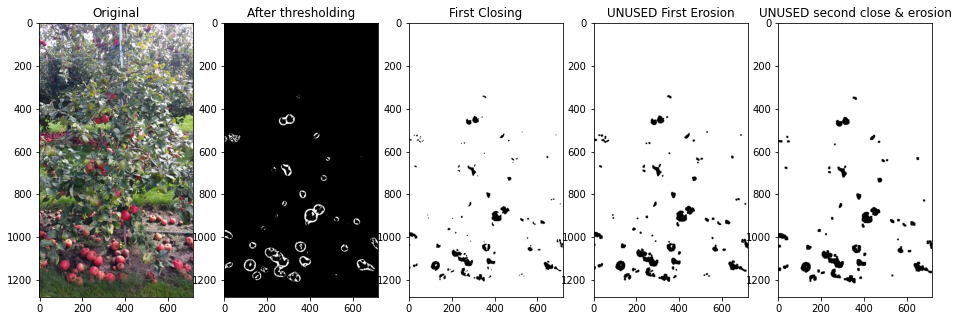

In [ ]:
# closing
kernel = np.ones((2,2),np.uint8) # create a structuring element
closing = cv2.morphologyEx(bw2, cv2.MORPH_CLOSE, kernel, iterations=3)

# erosion
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
erosion = cv2.erode(closing,kernel,iterations = 2)

# closing 2
kernel = np.ones((2,2),np.uint8)
closing2 = cv2.morphologyEx(erosion, cv2.MORPH_CLOSE, kernel, iterations=6)

# erosion 2
kernel = np.ones((2,2),np.uint8)
erosion2 = cv2.erode(closing2,kernel,iterations = 1)


plt.figure(figsize=(16, 16))
plt.subplot(1,5,1)
plt.imshow(img[:,:,::-1],cmap="gray")
plt.title("Original")
plt.subplot(1,5,2)
plt.imshow(bw3,cmap="gray")
plt.title("After thresholding")
plt.subplot(1,5,3)
plt.imshow(closing,cmap="gray")
plt.title("First Closing")
plt.subplot(1,5,4)
plt.imshow(erosion,cmap="gray")
plt.title("UNUSED First Erosion")
plt.subplot(1,5,5)
plt.imshow(erosion2,cmap="gray")
plt.title("UNUSED second close & erosion")

Find centroids of isolated clusters/blobs

There are 74 apples


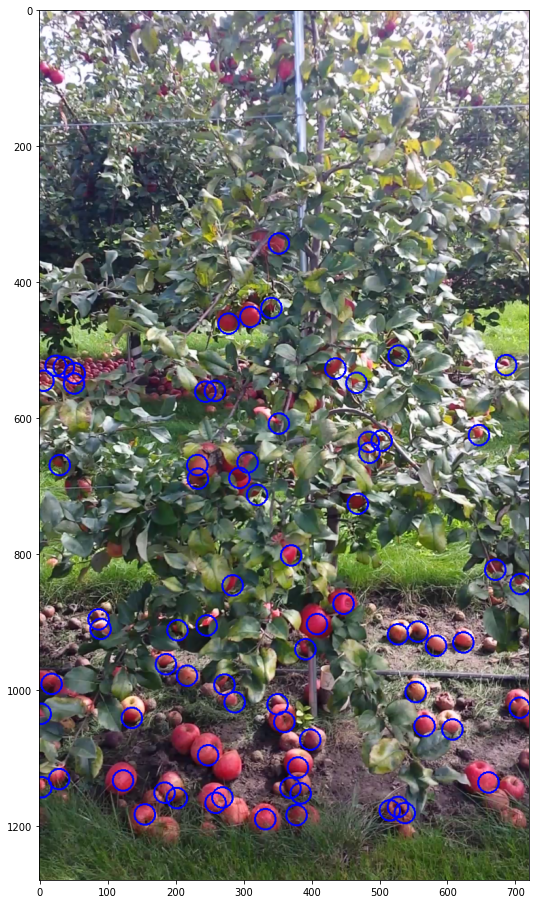

In [ ]:
display = img.copy()

result = np.invert(erosion)

labels, nlabels = ndimage.label(result)  # Label features in an array. Any non-zero values in input are counted as features and zero values are considered the background.
print("There are " + str(nlabels) + " apples")

centroid = ndimage.center_of_mass(result, labels, np.arange(nlabels) + 1 ) # calculate the center of mass of the values of an array at labels.

# draw circles representing the centroids
for cen in centroid:
  display = cv2.circle(display, (cen[1].astype(int), cen[0].astype(int)), radius=15, color=(255, 0, 0), thickness=2)

plt.figure(figsize=(16, 16))
plt.imshow(display[:,:,::-1])
